# Kaggle Titanic challenge

## Initial imports

In [2]:
# Load system libraries.
import os
import re
import sys
import collections
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

# Libraries for data wrangling.
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import joblib
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Machine learning.
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Visualization libraries.
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_context('poster')
sns.set(rc={'figure.figsize': (3, 3)})
sns.set_style('whitegrid')
tqdm = functools.partial(tqdm.tqdm, file=sys.stdout, position=0, leave=True)

# Local modules.
%load_ext autoreload
%autoreload 2
from src import kaggle_api, titanic

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [23]:
# Load the train and test data.
train = pd.read_csv('data/train.csv', index_col='PassengerId')
test = pd.read_csv('data/test.csv', index_col='PassengerId')
train_test = pd.concat([train, test])

train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory analysis

What type of columns do we have, and what are their distributions?

In [102]:
print('Numerical columns:')
display(train.describe(include=np.number))
print('Categorical columns:')
display(train.describe(exclude=np.number))
print('Missing values:')
display(pd.concat([
    train_df.iloc[:, 1:].isna().sum().rename('train'),
    test_df.isna().sum().rename('test')
], axis=1))

Numerical columns:


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Categorical columns:


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Marvin, Mr. Daniel Warner",male,347082,G6,S
freq,1,577,7,4,644


Missing values:


,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


The data inclues 10 columns of different types and complexity:
- Simple categorical values: `Sex`, `Embarked`, and `Pclass`.
- Discrete values: `SibSp` and `Parch`.
- Continuous values: `Age` (slightly skewed) and `Fare` (highly skewed).
- More complex values: `Ticket`, `Cabin`, and `Name`.

_Note: `Age` and `Cabin` contain many missing values._

### Simple categorical values

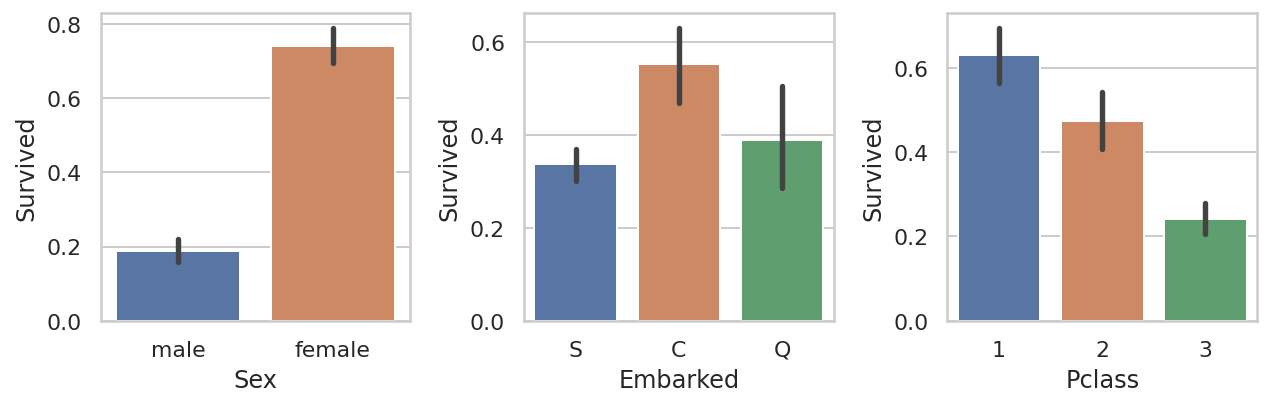

In [116]:
categorical_columns = ['Sex', 'Embarked', 'Pclass']

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, categorical_column in enumerate(categorical_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

All categorical values are strongly indicative of survival. Females, first-class tickets holders, and passengers that embarked at Cherbourg have the highest survival rates.

### Discrete values

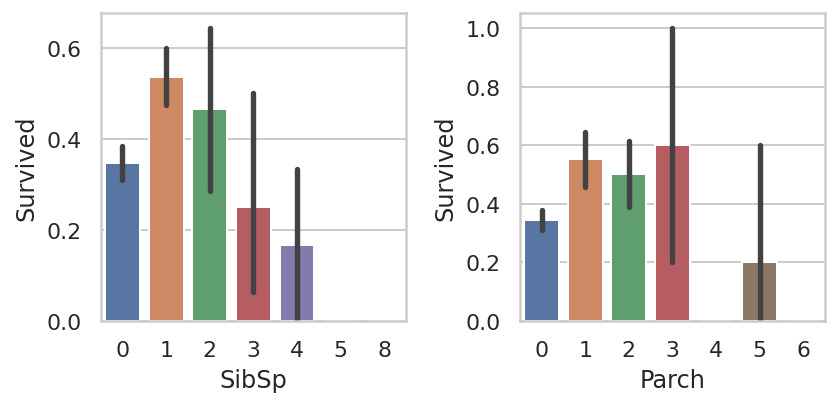

In [117]:
discrete_columns = ['SibSp', 'Parch']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.barplot(data=train, x=categorical_column, y='Survived', ax=axes[i])
plt.tight_layout()

The number of relatives is moderately indicative of survival. Passengers without any relatives are less likely to survive. 

### Continuous values

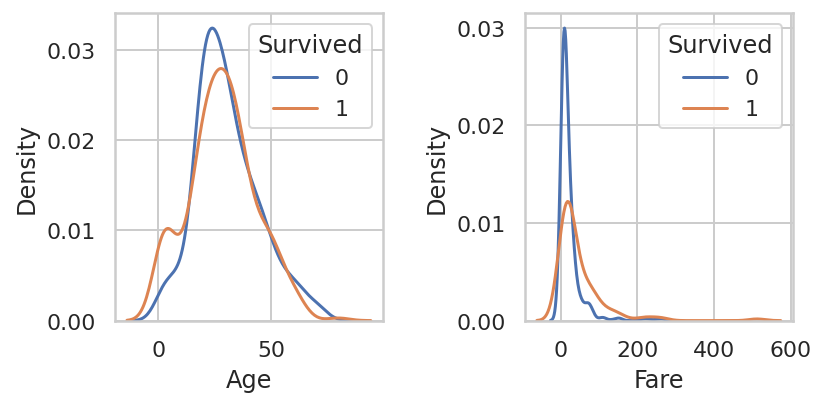

In [181]:
discrete_columns = ['Age', 'Fare']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.kdeplot(data=train[train['Survived'] == 0], x=categorical_column, ax=axes[i], label='0')
    sns.kdeplot(data=train[train['Survived'] == 1], x=categorical_column, ax=axes[i], label='1')
    axes[i].legend(title='Survived')
plt.tight_layout()

Both age and fare are weakly indicative of survival. A higher fare correlates with higher survival rate (possibly because of a better ticket class), and younger passengers are more likely to survive.

### More complex values

#### Name

In [53]:
train['Name'].sort_values().head()

PassengerId
846                      Abbing, Mr. Anthony
747              Abbott, Mr. Rossmore Edward
280         Abbott, Mrs. Stanton (Rosa Hunt)
309                      Abelson, Mr. Samuel
875    Abelson, Mrs. Samuel (Hannah Wizosky)
Name: Name, dtype: object

The name of the passenger includes their title, i.e. their social status, which could be indicate of survival. In addition, the last name of the passengers could indicate familes that traveled together, and may have similar fates.

#### Cabin number

In [51]:
train.loc[~train['Cabin'].isna(), 'Cabin'].sample(50).sort_values().to_numpy()

array(['A19', 'A20', 'B101', 'B102', 'B18', 'B3', 'B30', 'B4', 'B49',
       'B49', 'B5', 'B50', 'B77', 'B96 B98', 'C110', 'C111', 'C118',
       'C124', 'C126', 'C2', 'C22 C26', 'C32', 'C46', 'C49', 'C65', 'C7',
       'C83', 'D', 'D', 'D10 D12', 'D20', 'D21', 'D30', 'D35', 'D35',
       'D49', 'E101', 'E101', 'E17', 'E24', 'E40', 'E44', 'E50', 'E58',
       'E63', 'F G73', 'F38', 'G6', 'G6', 'T'], dtype=object)

The cabin number includes the deck (the letter of `Cabin`). It also indicates whether the cabin is in the bow or stern of the ship, as lower numbers are towards the stern, and higher numbers are towards the bow. Finally, similar to the last name, some passengers shared the same cabin, which could indicate similar fates.

#### Ticket number

In [49]:
train['Ticket'].sample(50).sort_values().to_numpy()

array(['113051', '113056', '113501', '113760', '113773', '113800',
       '12233', '19950', '237668', '250647', '2651', '2653', '2671',
       '2677', '28403', '335097', '343095', '345773', '345774', '345783',
       '347063', '347468', '349201', '349240', '349242', '363291',
       '364516', '365222', '36928', '36973', '370371', '374910', '382652',
       '386525', '4133', '693', 'A/5. 851', 'A4. 54510', 'C 7075',
       'C.A. 2315', 'C.A. 5547', 'CA 2144', 'PC 17558', 'PC 17569',
       'PC 17601', 'PC 17755', 'SOTON/O.Q. 3101311', 'SOTON/O2 3101272',
       'W./C. 6608', 'WE/P 5735'], dtype=object)

Some ticket numbers include letters indicative of port of entry, ticket class, and cabin number. However, as we already have that information, it can be ignored. Some passengers have the same ticket number, which could tell us who traveled together, even if they had different names and their cabin is unknown (e.g. some children traveled alone with a nanny). The number of passengers per ticket could also tell us the fare price per person, which may have a significantly different distribution compared to the fare per ticket.

## Data cleaning

### Extracting data from more complex columns

From the exploratory analysis, we have good idea about what potentially useful information can be extracted from `Name` and `Cabin` columns:

- The title (i.e. "importance") of a passenger.
- The last name to determine which passengers are likely to be part of the same family.
- The deck of the cabin.
- The numerical value of the cabin to approximate its location.

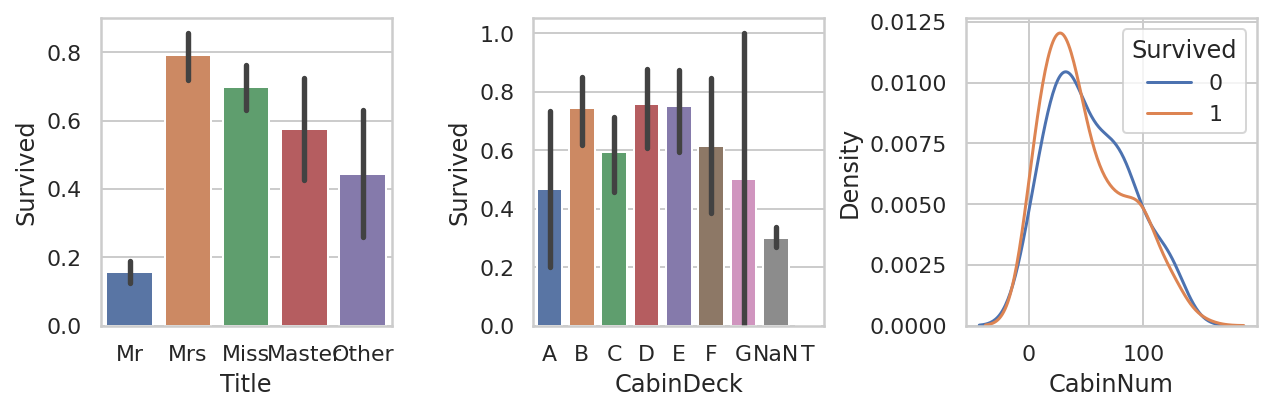

In [66]:
# Fix the one name that is in a different format from the rest.
train = train.replace(
    'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)', 
    'Dyer-Edwards, Countess. Lucy Noel Martha'
)

# Iterate over both train and test datasets.
for df in (train, test):
    
    # Extract title and last name.
    extracted = df['Name'].str.extract(r"^(.+?),\s(\w+)\.")
    df['LastName'] = extracted[0]
    df['Title'] = extracted[1]
    
    # Replace infrequent titles with 'Other'
    df.loc[~df['Title'].isin(['Mr', 'Mrs', 'Miss', 'Master']), 'Title'] = 'Other'

    # Extract cabin deck and number.
    train['CabinDeck'] = train['Cabin'].str.slice(0, 1).fillna('NaN')
    train['CabinNum'] = train['Cabin'].str.extract(r'(\d+)$').astype(float)
    
# Plot extracted values.
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sns.barplot(data=train, x='Title', y='Survived', ax=axes[0])
sns.barplot(data=train, x='CabinDeck', y='Survived', ax=axes[1], order=sorted(train['CabinDeck'].unique()))
sns.kdeplot(data=train[train['Survived'] == 0], x='CabinNum', label='0', ax=axes[2])
sns.kdeplot(data=train[train['Survived'] == 1], x='CabinNum', label='1', ax=axes[2])
axes[2].legend(title='Survived')
plt.tight_layout()

Title is highly indicative of survival. This is heavily affected by sex and age, but could include novel information such as perceived social importance. 

The cabin deck does not seem to be indicative of survival. However, passengers without a known cabin number are less likely to survive. This could be because the cabin number is known for the majority of class A passengers. However, it could also include novel information, e.g. survivors would be able to share/record the cabin number after reaching shore.

Passengers with a higher cabin number are slightly less likely to survive. This could be affected by class status as well, as some decks have fewer number of cabins, but it could also inlude novel information such proximity to the stern/bow.

### Dealing with missing values

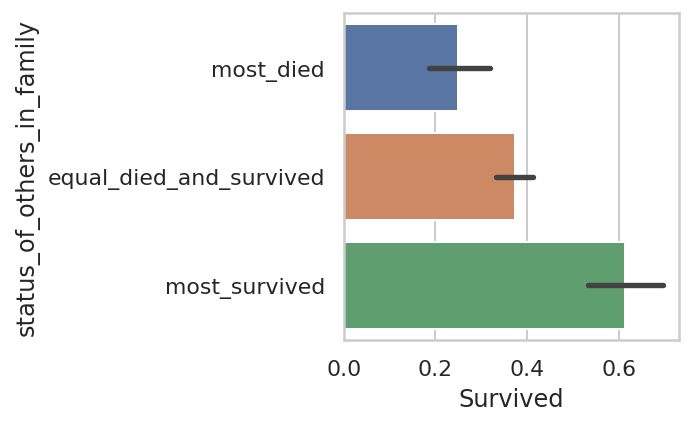

In [15]:

sns.barplot(data=train, y='status_of_others_in_family', x='Survived');

#### Cabin number

Three potential pieces of information can be gained from the cabin number:
- The deck of the cabin (the letter of the cabin).
- Whether the cabin is in the bow or stern of the ship (the number of the cabin).
- Which people were together in the same cabin.

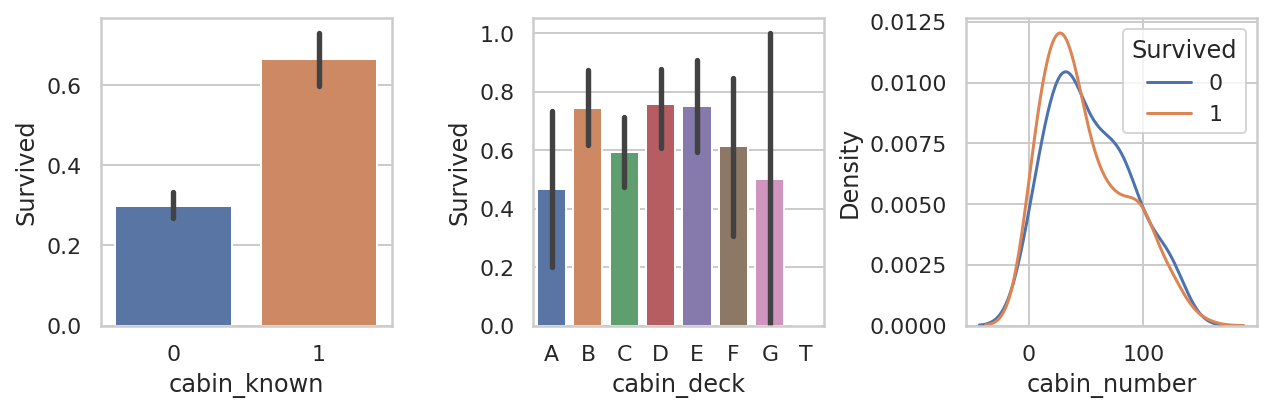

In [374]:
train['cabin_known'] = (~train['Cabin'].isna()).astype(int)
train['cabin_deck'] = train['Cabin'].str.slice(0, 1)
train['cabin_number'] = train['Cabin'].str.extract(r'(\d+)$').astype(float)

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
sns.barplot(data=train, x='cabin_known', y='Survived', ax=axes[0])
sns.barplot(data=train, x='cabin_deck', y='Survived', order=sorted(train['cabin_deck'].fillna('A').unique()), ax=axes[1])
sns.kdeplot(data=train[train['Survived'] == 0], x='cabin_number', label='0', ax=axes[2])
sns.kdeplot(data=train[train['Survived'] == 1], x='cabin_number', label='1', ax=axes[2])
axes[2].legend(title='Survived')
plt.tight_layout()

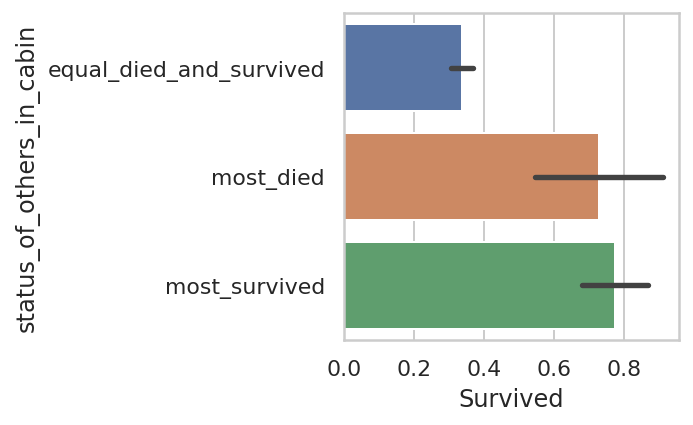

In [16]:
train['status_of_others_in_cabin'] = titanic.status_of_others_sharing_factor('Cabin', train)
sns.barplot(data=train, y='status_of_others_in_cabin', x='Survived');

#### Ticket number

Some passengers share the same ticket, giving two addition pieces of information:
- Who travelled together (even if they had different last names).
- The price of the ticket per person.

_Some ticket numbers also include letters indicative of port of entry and ticket class, but we already have that information, so it can be ignored._

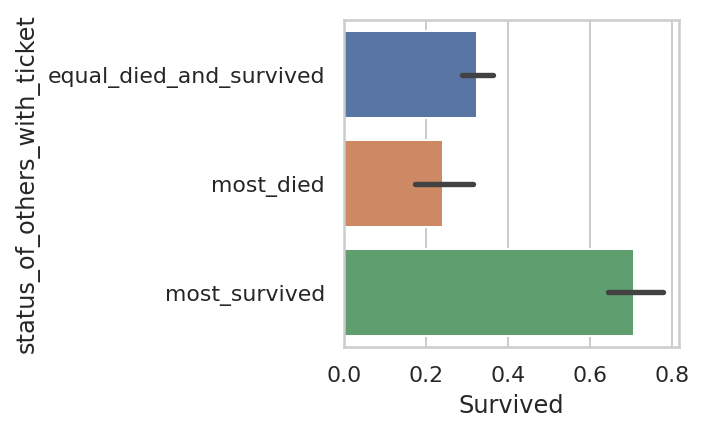

In [27]:
train['status_of_others_with_ticket'] = titanic.status_of_others_sharing_factor('Ticket', train)
sns.barplot(data=train, y='status_of_others_with_ticket', x='Survived');

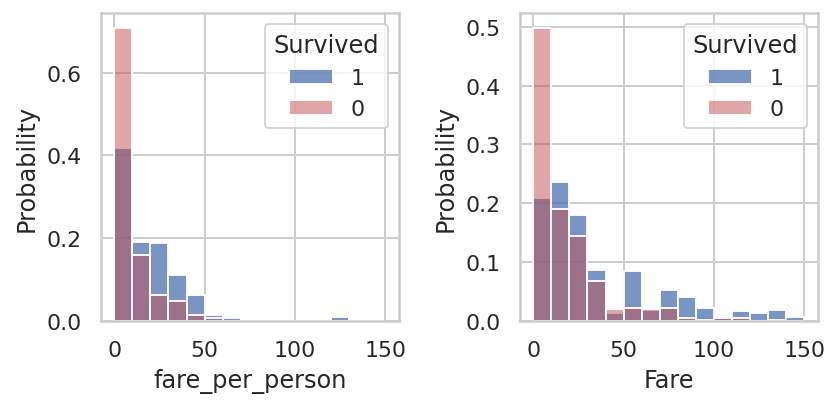

In [46]:
train['person_per_ticket'] = train_test.assign(n=1).groupby('Ticket')['n'].transform('count')
train['fare_per_person'] = train['Fare'] / train['person_per_ticket']

discrete_columns = ['fare_per_person', 'Fare']

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
for i, categorical_column in enumerate(discrete_columns):
    sns.histplot(data=train[train['Survived'] == 1], x=categorical_column, ax=axes[i], label='1', stat='probability', binrange=(0, 150), bins=15)
    sns.histplot(data=train[train['Survived'] == 0], x=categorical_column, ax=axes[i], label='0', stat='probability', binrange=(0, 150), bins=15, color='r', alpha=0.5)
    axes[i].legend(title='Survived')
plt.tight_layout()

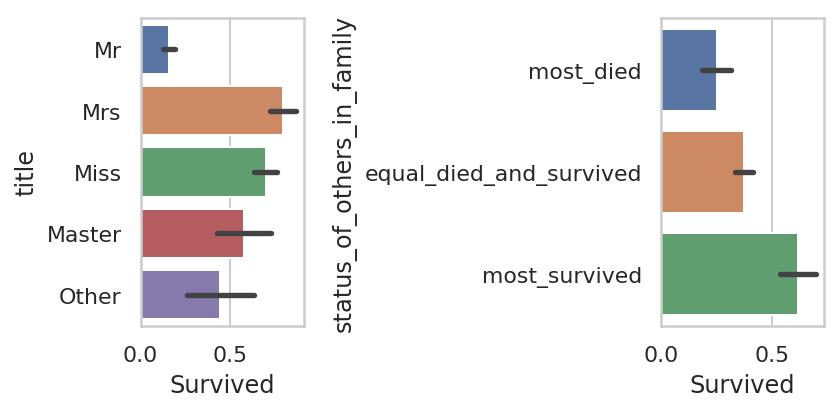

In [59]:
# Determine the survival status of others with the same last name.
train['status_of_others_in_family'] = titanic.status_of_others_sharing_factor('last_name', train)


# Plot the clea
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
sns.barplot(data=train, y='status_of_others_in_family', x='Survived', ax=axes[1])

plt.tight_layout()


## Clean data

,train,test
Pclass,0,0
Name,0,0
Sex,0,0
Age,177,86
SibSp,0,0
Parch,0,0
Ticket,0,0
Fare,0,1
Cabin,687,327
Embarked,2,0


In [6]:
test_submission = (test['Sex'] != 'male').rename('Survived').astype(int)
kaggle_api.submit('titanic', test_submission, 'Test submission from API that should fail')

100%|██████████| 2.77k/2.77k [00:00<00:00, 4.33kB/s]


'0.76555'